# Human exposure

In [1]:
!make -C .. scenarios statpop

make: Entering directory '/home/martibosch/data-science/lausanne-greening-scenarios'
make: Nothing to be done for 'scenarios'.
make: Nothing to be done for 'statpop'.
make: Leaving directory '/home/martibosch/data-science/lausanne-greening-scenarios'


In [2]:
import tempfile
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salem
import seaborn as sns
import swiss_uhi_utils as suhi
import swisslandstats as sls
import xarray as xr
from affine import Affine

from lausanne_greening_scenarios import utils

In [3]:
agglom_extent_filepath = '../data/raw/agglom-extent/agglom-extent.shp'
statpop_filepath = '../data/raw/statpop/statpop-2019.csv'

scenario_ds_filepath = '../data/processed/scenarios.nc'

In [4]:
agglom_extent_gdf = gpd.read_file(agglom_extent_filepath)
ldf = sls.read_csv(statpop_filepath, x_column='E_KOORD', y_column='N_KOORD')
agglom_ldf = ldf.clip_by_geometry(
    geometry=agglom_extent_gdf.iloc[0]['geometry'],
    geometry_crs=agglom_extent_gdf.crs)
agglom_ldf['total'] = agglom_ldf[[f'B19B{sex}TOT'
                                  for sex in ['M', 'W']]].sum(axis=1)
with tempfile.TemporaryDirectory() as tmp_dir:
    tmp_filepath = path.join(tmp_dir, f'agglom-pop.tif')
    agglom_ldf.to_geotiff(tmp_filepath, 'total')
    agglom_pop_da =  salem.open_xr_dataset(tmp_filepath)['data']

In [5]:
num_change_props = 5
change_props = np.linspace(0, 1, num_change_props)

scenario_T_da = xr.open_dataset(scenario_ds_filepath)['T'].sel(
        change_prop=change_props)
scenario_T_da = xr.concat([
    suhi.align_ds(group_T_da, agglom_pop_da)
    for change_prop, group_T_da in scenario_T_da.groupby('change_prop')
],
                          dim='change_prop')

In [6]:
T_step = 1
T_ser = pd.Series(np.arange(np.floor(scenario_T_da.min().item()),
                            np.ceil(scenario_T_da.max().item()), T_step),
                  name='T')

In [7]:
change_props = scenario_T_da['change_prop']
interactions = scenario_T_da['interaction'].data
scenario_runs = scenario_T_da['scenario_run'].data
pop_count_df = pd.concat([
    pd.DataFrame(
        pd.DataFrame(np.array([
            agglom_pop_da.where(
                scenario_T_da.sel(interaction=interaction,
                                  scenario_run=scenario_run) > T,
                0).sum(dim=['x', 'y']).data for T in T_ser
        ]),
                     index=T_ser,
                     columns=change_props).stack().rename('count')).assign(
                         interaction=interaction, scenario_run=scenario_run)
    for interaction in interactions for scenario_run in scenario_runs
],
                    axis=0).reset_index()
# by default, it is uint16, which will be problematic when computing differences
pop_count_df['count'] = pop_count_df['count'].astype(np.int32)

Let us now list the average number of dwellers exposed to each temperature for each proportion of changed pixels (averaged out of all the sampling approaches and scenario runs):

In [8]:
pop_count_df.groupby(['T', 'change_prop'])['count'].mean()

T     change_prop
20.0  0.00           275217.000000
      0.25           275217.000000
      0.50           275217.000000
      0.75           275217.000000
      1.00           275217.000000
21.0  0.00           275021.000000
      0.25           274965.333333
      0.50           274891.833333
      0.75           274769.933333
      1.00           274655.000000
22.0  0.00           267302.000000
      0.25           265899.200000
      0.50           263331.800000
      0.75           259414.533333
      1.00           255640.000000
23.0  0.00           249306.000000
      0.25           241564.833333
      0.50           228330.133333
      0.75           206328.566667
      1.00           175917.000000
24.0  0.00           207894.000000
      0.25           189562.100000
      0.50           138397.866667
      0.75            62139.533333
      1.00            23224.000000
25.0  0.00           124073.000000
      0.25            69268.933333
      0.50            14368.400000
  

Since the number of dwellers exposed to temperatures higher than 20 does not change, let us ommit them in the remainder.

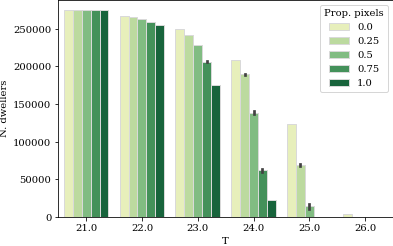

In [9]:
pop_count_df = pop_count_df[pop_count_df['T'] > 20]
ax = sns.barplot(x='T',
                 y='count',
                 hue='change_prop',
                 data=pop_count_df,
                 palette='YlGn')
ax.set_ylabel('N. dwellers')
ax.legend().set_title('Prop. pixels')
ax.figure.savefig('../reports/figures/human-exposure.pdf')

Let us list the simulated number of dwellers exposed to each temperature for the initial and final scenarios, which are deterministic and independent of the sampling approach (and hence independent of the scenario run too):

In [10]:
groupby = ['change_prop', 'T']
endpoint_cond = (pop_count_df['change_prop'] == 0) | (
    pop_count_df['change_prop'] == 1)

pop_count_df[endpoint_cond].drop(['interaction', 'scenario_run'],
                                 axis=1).groupby(groupby).first()

count
change_prop T           
0.0         21.0  275021
            22.0  267302
            23.0  249306
            24.0  207894
            25.0  124073
            26.0    4628
1.0         21.0  274655
            22.0  255640
            23.0  175917
            24.0   23224
            25.0       0
            26.0       0

Let us now list the same information for each sampling approach and proportion of transformed pixels (averaged out of all the scenario runs):

In [11]:
pop_count_df[~endpoint_cond].drop(
    'scenario_run', axis=1).groupby(['interaction'] + groupby).mean()

count
interaction change_prop T             
cluster     0.25        21.0  274942.7
                        22.0  265957.8
                        23.0  240244.1
                        24.0  187221.3
                        25.0   74466.4
                        26.0       0.0
            0.50        21.0  274859.1
                        22.0  263852.3
                        23.0  229215.2
                        24.0  144893.2
                        25.0   25886.0
                        26.0       0.0
            0.75        21.0  274754.2
                        22.0  259873.8
                        23.0  207393.2
                        24.0   70278.8
                        25.0       0.0
                        26.0       0.0
random      0.25        21.0  274960.9
                        22.0  265788.3
                        23.0  242004.4
                        24.0  190518.1
                        25.0   68232.8
                        26.0       0.0
            0.50        21.0  274888.9
                        22.0  262944.2
                        23.0  226870.3
                        24.0  135822.1
                        25.0   12721.3
                        26.0       0.0
            0.75        21.0  274732.1
                        22.0  259002.9
                        23.0  204210.2
                        24.0   58640.6
                        25.0       0.0
                        26.0       0.0
scatter     0.25        21.0  274992.4
                        22.0  265951.5
                        23.0  242446.0
                        24.0  190946.9
                        25.0   65107.6
                        26.0       0.0
            0.50        21.0  274927.5
                        22.0  263198.9
                        23.0  228904.9
                        24.0  134478.3
                        25.0    4497.9
                        26.0       0.0
            0.75        21.0  274823.5
                        22.0  259366.9
                        23.0  207382.3
                        24.0   57499.2
                        25.0       0.0
                        26.0       0.0

## Comparison of sampling approaches

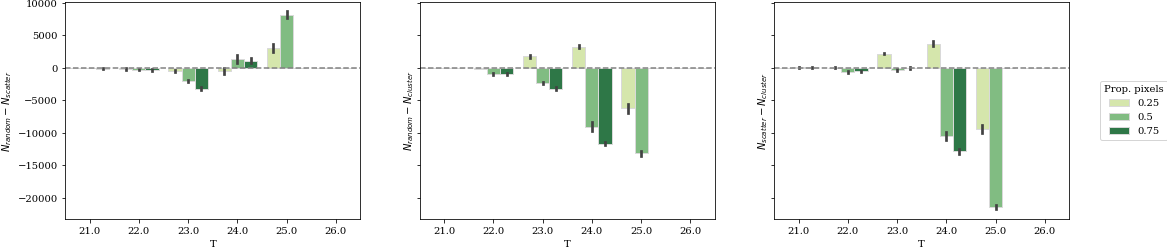

In [12]:
comparison_df = utils.get_comparison_df(pop_count_df[~endpoint_cond], 'count')

fig = utils.plot_approach_comparison(comparison_df,
                                     'T',
                                     'change_prop',
                                     palette='YlGn')

# legend for only the last axis and outside it
for ax in fig.axes[:-1]:
    ax.get_legend().remove()
ax = fig.axes[-1]
h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(h,
          l,
          title='Prop. pixels',
          loc='center right',
          bbox_to_anchor=(1.35, .5))

fig.savefig('../reports/figures/human-exposure-comparison.pdf')

Let us now list, for each proportion of transformed pixels, the absolute differences between the number of dwellers exposed to each temperature (averaged out of all the scenario runs):

In [13]:
utils.get_absolute_comparison_df(comparison_df, groupby, y='count')

count  random-scatter  random-cluster  scatter-cluster
change_prop T                                                              
0.25        21.0  274960.9           -31.5            18.2             49.7
            22.0  265788.3          -163.2          -169.5             -6.3
            23.0  242004.4          -441.6          1760.3           2201.9
            24.0  190518.1          -428.8          3296.8           3725.6
            25.0   68232.8          3125.2         -6233.6          -9358.8
            26.0       0.0             0.0             0.0              0.0
0.50        21.0  274888.9           -38.6            29.8             68.4
            22.0  262944.2          -254.7          -908.1           -653.4
            23.0  226870.3         -2034.6         -2344.9           -310.3
            24.0  135822.1          1343.8         -9071.1         -10414.9
            25.0   12721.3          8223.4        -13164.7         -21388.1
            26.0       0.0             0.0             0.0              0.0
0.75        21.0  274732.1           -91.4           -22.1             69.3
            22.0  259002.9          -364.0          -870.9           -506.9
            23.0  204210.2         -3172.1         -3183.0            -10.9
            24.0   58640.6          1141.4        -11638.2         -12779.6
            25.0       0.0             0.0             0.0              0.0
            26.0       0.0             0.0             0.0              0.0

Finally, let us list the same information but in relative terms, i.e., divided by the reduction in the number of dwellers for each proportion of transformed pixels and temperature (averaged over all sampling approaches and simulation runs).

In [14]:
utils.get_relative_comparison_df(comparison_df, groupby, 'count').fillna(0)

random-scatter  random-cluster  scatter-cluster
change_prop T                                                    
0.25        21.0       -0.000115        0.000066         0.000181
            22.0       -0.000614       -0.000638        -0.000024
            23.0       -0.001825        0.007273         0.009099
            24.0       -0.002260        0.017299         0.019559
            25.0        0.045680       -0.091521        -0.137201
            26.0        0.000000        0.000000         0.000000
0.50        21.0       -0.000140        0.000108         0.000249
            22.0       -0.000969       -0.003454        -0.002485
            23.0       -0.008969       -0.010337        -0.001368
            24.0        0.009862       -0.066840        -0.076702
            25.0        0.645666       -1.039162        -1.684827
            26.0        0.000000        0.000000         0.000000
0.75        21.0       -0.000333       -0.000080         0.000252
            22.0       -0.001406       -0.003363        -0.001957
            23.0       -0.015535       -0.015590        -0.000055
            24.0        0.019414       -0.198485        -0.217899
            25.0        0.000000        0.000000         0.000000
            26.0        0.000000        0.000000         0.000000